In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path = [os.path.abspath('../')] + sys.path

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'



In [24]:
from experiments.create_assets.learned_coeffs import learn_coeffs
from experiments.create_assets.coeffs import plot_coeffs_3_decays_5_coeffs, mus_alphas_from_coeffs

Launching the solver AGD...
  n_iter  |    obj    |    step   |  rel_obj 
      300 | -1.24e+00 |  1.28e-01 |  9.17e-06
      600 | -1.24e+00 |  1.28e-01 |  1.61e-08
Done solving using AGD in 1.1563642024993896 seconds


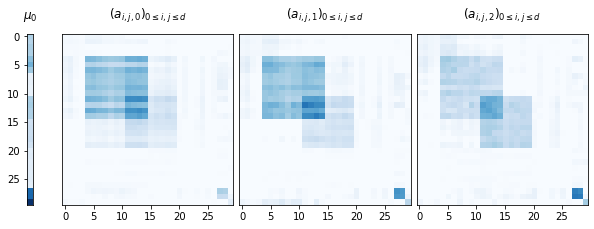

In [36]:
dim_ = 30
n_decays_ = 3
end_time_ = 20000
prox_name_ = 'nuclear' #'l1w_nuclear' # 'l1_nuclear' #
lambda_file = 'used_lambdas_v1_30_models.csv'

learn_coeffs(dim_, n_decays_, end_time_, prox_name_, lambda_file)

../experiments/create_assets/original_coeffs_dim_30_decays_3.npy
coeffs_l1_dim_30_decays_3_T_20000.npy
coeffs_l1w_dim_30_decays_3_T_20000.npy
coeffs_nuclear_dim_30_decays_3_T_20000.npy
coeffs_l1_nuclear_dim_30_decays_3_T_20000.npy
coeffs_l1w_nuclear_dim_30_decays_3_T_20000.npy


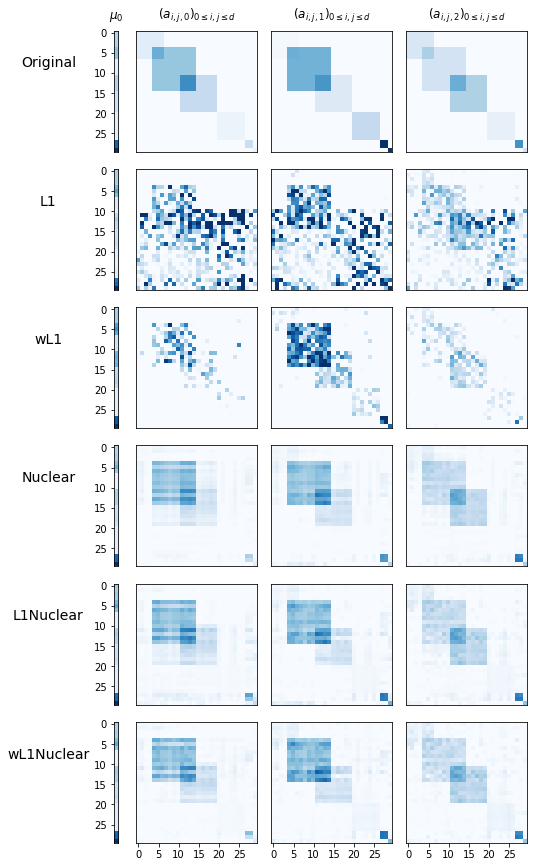

In [42]:
import numpy as np
import matplotlib.pyplot as plt

original_coeffs_file_path_ = '../experiments/create_assets/original_coeffs_dim_30_decays_3.npy'
originalcoeffs_ = np.load(original_coeffs_file_path_, allow_pickle=True)
o_baseline_, o_adjacency_ = mus_alphas_from_coeffs(originalcoeffs_, n_decays_)

coeffs_file_paths_ = [original_coeffs_file_path_]
labels = ['Original', 'L1', 'wL1', 'Nuclear', 'L1Nuclear', 'wL1Nuclear']
for prox_name in ['l1', 'l1w', 'nuclear', 'l1_nuclear', 'l1w_nuclear']:
    coeffs_file_path_ = 'coeffs_{}_dim_{}_decays_{}_T_{}.npy'\
        .format(prox_name, dim_, n_decays_, end_time_)
    coeffs_file_paths_ += [coeffs_file_path_]
        
plot_coeffs_3_decays_5_coeffs(coeffs_file_paths_, labels,
                                  max_adjacency=o_adjacency_.max())
plt.savefig('learned_coeffs.pdf')

In [ ]:
import matplotlib.pyplot as plt
from multiprocessing import cpu_count
from collections import OrderedDict

from experiments.tested_prox import (
    create_prox_l1_no_mu, create_prox_l1w_no_mu,
    create_prox_l1_no_mu_nuclear, create_prox_l1w_no_mu_nuclear,
    create_prox_nuclear
)
from experiments.sensitivity_to_regularization_constant import (
    get_metrics_for_strength_range, plot_metrics_for_strength_range,
    get_range_for_metric
)


directory_path = '/home/m.bompaire/experiments/hawkes_data/'

dim = 30
n_cpu = cpu_count() - 1
run_time = 10000
n_models = 100

n_decays = 3

strength_range = [1e-8, 1e-7]#, (1e-08, 0.01), (1e-05, 1e-08), (1e-05, 1e-05), (1e-05, 0.01), (0.01, 1e-08), (0.01, 1e-05), (0.01, 0.01)]
prox_infos = OrderedDict()

prox_infos['l1'] = {
    'n_initial_points': 10,
    'max_relative_step': 1.4,
    'create_prox': create_prox_l1_no_mu,
    'tol': 1e-1,
    'dim': 1,
}

prox_infos['l1w'] = {
    'n_initial_points': 10,
    'max_relative_step': 1.4,
    'create_prox': create_prox_l1w_no_mu,
    'tol': 1e-10,
    'dim': 1,
}

prox_infos = OrderedDict(
    (prox_name, dict(name=prox_name, **prox_info)) for prox_name, prox_info in prox_infos.items())

In [2]:
prox_info = prox_infos['l1w']

In [11]:
import numpy as np
training_suffix = '100_x_25000_iter'
metrics = ['alpha_auc', 'estimation_error', 'kendall']
suffix = 'width_10'

In [12]:
strengths_to_learn = np.array([
    get_range_for_metric(dim, run_time, prox_info, metric, training_suffix=training_suffix)
    for metric in metrics
]).reshape(-1)

solver_kwargs = {'tol': 1e-10, 'max_iter': 25000}
get_metrics_for_strength_range(strength_ranges, dim, run_time, n_decays, n_models, prox_info,
                               solver_kwargs, directory_path, n_cpu=n_cpu, suffix=suffix)

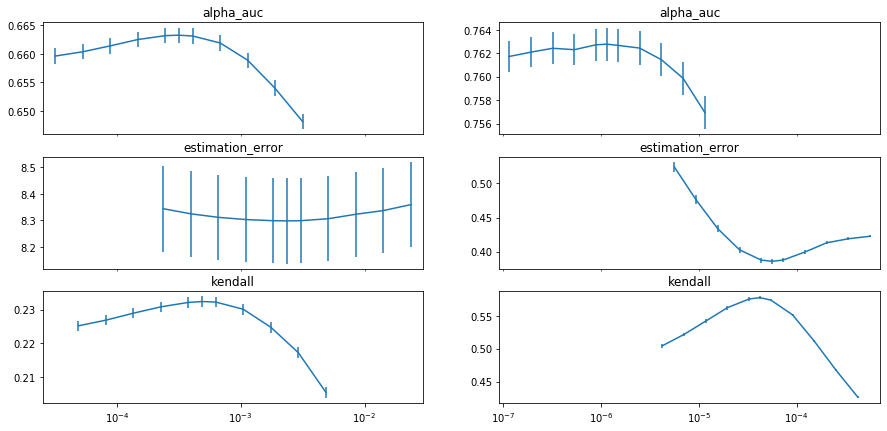

In [13]:
fig, axes = plt.subplots(3, 2, figsize=(15, 7))
from tick.plot.plot_utilities import share_x

for i, prox_name in enumerate(['l1', 'l1w']):
    for j, metric in enumerate(['alpha_auc', 'estimation_error', 'kendall']):
        prox_info = prox_infos[prox_name]
        ax = axes[j, i]
        strength_range = get_range_for_metric(dim, run_time, prox_info, metric, training_suffix=training_suffix)
        plot_metrics_for_strength_range(metric, prox_info, suffix=suffix, ax=ax, strength_range=strength_range)
        ax.set_title(metric)
    share_x(axes[:, i].reshape(-1, 1))